In [26]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import numpy as np
import os

def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]


mnist = fetch_mldata('MNIST original')
X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits. 
y_test_5 = (y_test == 5)

from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

from sklearn.model_selection import StratifiedKFold 
from sklearn.base import clone

# Homemade Cross Validation
 
# skfolds = StratifiedKFold(n_splits=5, random_state=42)
# for train_index, test_index in skfolds.split(X_train, y_train_5):
#     clons_clf = clone(sgd_clf)
#     X_train_folds = X_train[train_index]
#     y_train_folds = y_train_5[train_index]
    
#     X_test_folds = X_train[test_index]
#     y_test_fonds = y_train_5[test_index]
    
#     clons_clf.fit(X_train_folds, y_train_folds)
#     predicts = clons_clf.predict(X_test_folds)
#     n_correct = sum(predicts==y_test_fonds)
#     print('precision:',n_correct*1.0/y_test_fonds.shape[0])
    
# OutofBox Cross Validation

from sklearn.model_selection import cross_val_score
cross_val = cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")
print("cross_val:",cross_val)

# NoNoNo Estimator
from sklearn.base import BaseEstimator
class Never5Estimator(BaseEstimator):
    def fit(self,X,y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)
    
cross_val = cross_val_score(Never5Estimator(), X_train, y_train_5, cv=3, scoring="accuracy")
# skewed datasets
print("cross_val:",cross_val)


cross_val: [0.9483  0.9468  0.96025]
cross_val: [0.9114  0.90885 0.9087 ]


In [29]:
# So introducing confusion matrix
from sklearn.model_selection import cross_val_predict
# instead of returning the evaluation scores, it returns the predictions made on each test fold.
y_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_pred)

from sklearn.metrics import precision_score, recall_score, f1_score
print('precision score',precision_score(y_train_5, y_pred))
print('recall score',recall_score(y_train_5, y_pred))
print('f1 score',f1_score(y_train_5, y_pred))

precision score 0.7451512800620637
recall score 0.7087253274303634
f1 score 0.7264819892218966


In [30]:
# Decision Function
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([264963.35534313])

In [32]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
y_scores

array([ -442096.1794355 ,  -567807.65063685,  -484832.36220258, ...,
        -121111.72459545,  -545151.09792565, -1631338.59139574])

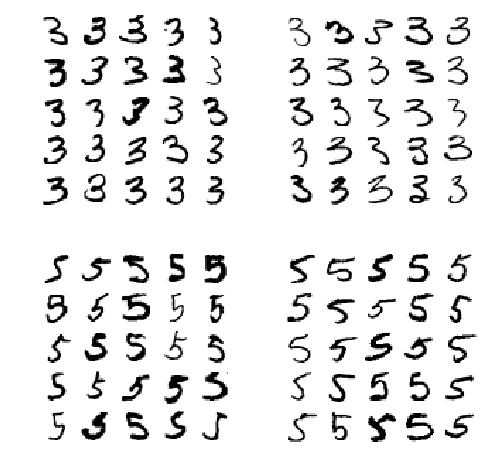

In [53]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt


precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds): 
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision") 
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall") 
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
%matplotlib inline
# plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
# plt.show()

# Precision versus recall
def plot_precision_vs_recall(precisions, recalls): 
    plt.plot(recalls[:-1], precisions[:-1], "b") 
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim([0, 1])
    
# plot_precision_vs_recall(precisions, recalls)
# plt.show()

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
def plot_roc_curve(fpr, tpr, label=None): 
    plt.plot(fpr, tpr, linewidth=2, label=label) 
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
# plot_roc_curve(fpr, tpr)
# plt.show()

# from sklearn.metrics import roc_auc_score
# roc_auc_score(y_train_5, y_scores)

# Plot Random Forrest RAC

# from sklearn.ensemble import RandomForestClassifier
# forest_clf = RandomForestClassifier(random_state=42)
# y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
# y_scores_forest = y_probas_forest[:, 1]
# fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

# plt.plot(fpr, tpr, "b:", label="SGD")
# plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
# plt.legend(loc="bottom right")
# plt.show()

# sgd_clf.fit(X_train, y_train)
# sgd_clf.predict([some_digit])
# some_digit_scores = sgd_clf.decision_function([some_digit]) # Multi Digit Score


# cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")
# Result: array([0.86472705, 0.83819191, 0.85567835])

# simply scaling the inputs (as discussed in Chapter 2) increases accuracy above 90%
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
# cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")
#Result array([0.91106779, 0.91044552, 0.90703606])



# Measure Error
# y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
# conf_mx = confusion_matrix(y_train, y_train_pred)

# plt.matshow(conf_mx, cmap=plt.cm.gray)
# plt.show()

# Focus on error
# row_sums = conf_mx.sum(axis=1, keepdims=True)
# norm_conf_mx = conf_mx / row_sums
# np.fill_diagonal(norm_conf_mx, 0)
# plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
# plt.show()

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

# cl_a, cl_b = 3, 5
# X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
# X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
# X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
# X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

# plt.figure(figsize=(8,8))
# plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
# plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
# plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
# plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
# plt.show()




In [57]:
# Multi Label
# from sklearn.neighbors import KNeighborsClassifier
# y_train_large = (y_train >= 7)
# y_train_odd = (y_train % 2 == 1)
# y_multilabel = np.c_[y_train_large, y_train_odd]
# knn_clf = KNeighborsClassifier()
# knn_clf.fit(X_train, y_multilabel)
# knn_clf.predict([some_digit])
# y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
# f1_score(y_train, y_train_knn_pred, average="macro")

# Exersize

import time
before = time.time()
knn_clf = KNeighborsClassifier()
scores = cross_val_score(knn_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")
# Result [0.94361128 0.94379719 0.93909086]
print('After ',time.time()-before)
print('Result is ',scores)

[0.94361128 0.94379719 0.93909086]
